### **Installing `scikit-learn`**

1. To install `scikit-learn` using `pip`, run the following command: `pip install -U scikit-learn`
2. To install `scikit-learn` using `conda`, run the following command: `conda install -c conda-forge scikit-learn`

In [ ]:
!pip install -U scikit-learn

---


### **Import Libraries**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import pickle

plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")



### **Load Dataset as DataFrame**

In [2]:
df = pd.read_csv("heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df['Oldpeak'].mean()

0.8873638344226579

In [4]:
# Target
y = df["HeartDisease"].astype(int)

# Features
X = df.drop("HeartDisease", axis=1)

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, drop_first=True)

feature_cols = X_encoded.columns.tolist()

label_map = {
    0: "Normal",
    1: "Heart Disease"
}

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [4]:
X_encoded.columns

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y',
       'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

In [5]:
rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)

dt_clf = DecisionTreeClassifier(
    max_depth=6,
    random_state=42,
    class_weight="balanced"
)

ada_clf = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)

rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)


,estimator,None
,n_estimators,200
,learning_rate,0.5
,algorithm,'deprecated'
,random_state,42


In [6]:
models = {
    "Random Forest": rf_clf,
    "Decision Tree": dt_clf,
    "AdaBoost": ada_clf
}

f1_scores = {}
for name, m in models.items():
    y_pred = m.predict(X_test)
    f1 = f1_score(y_test, y_pred, average="macro")
    f1_scores[name] = f1

f1_scores


{'Random Forest': 0.8951000690131126,
 'Decision Tree': 0.7922756981580511,
 'AdaBoost': 0.8956262128675923}

In [7]:
f1_vals = np.array(list(f1_scores.values()))
weights = f1_vals / f1_vals.sum()

model_names = list(f1_scores.keys())
weights_dict = dict(zip(model_names, weights))
weights_dict


{'Random Forest': 0.34653479785551006,
 'Decision Tree': 0.306726709573085,
 'AdaBoost': 0.3467384925714048}

#### **Evaluation on Test Set**

In [8]:
voting_clf = VotingClassifier(
    estimators=[
        ("rf", rf_clf),
        ("dt", dt_clf),
        ("ada", ada_clf)
    ],
    voting="soft",
    weights=[
        weights_dict["Random Forest"],
        weights_dict["Decision Tree"],
        weights_dict["AdaBoost"]
    ]
)

voting_clf.fit(X_train, y_train)

y_pred_vote = voting_clf.predict(X_test)

print(
    classification_report(
        y_test,
        y_pred_vote,
        target_names=[label_map[i] for i in sorted(label_map)]
    )
)


               precision    recall  f1-score   support

       Normal       0.83      0.83      0.83        82
Heart Disease       0.86      0.86      0.86       102

     accuracy                           0.85       184
    macro avg       0.85      0.85      0.85       184
 weighted avg       0.85      0.85      0.85       184



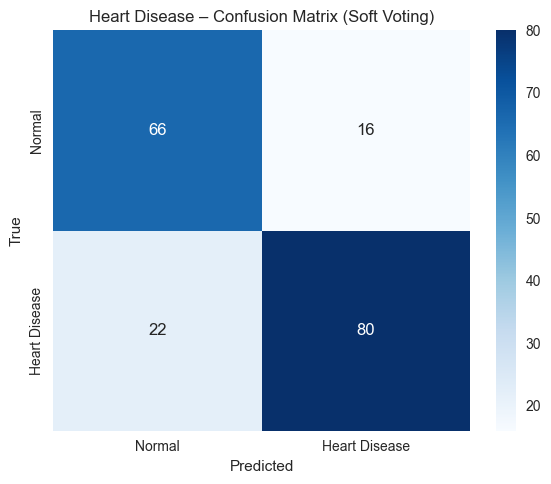

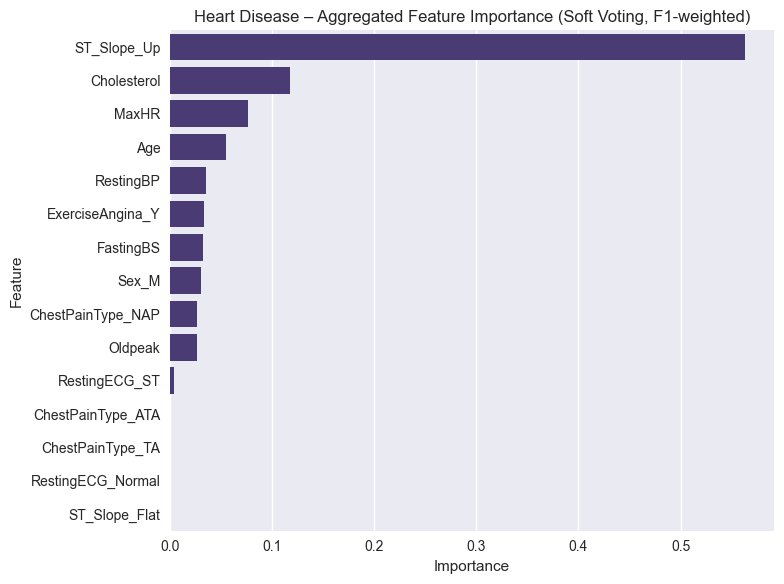

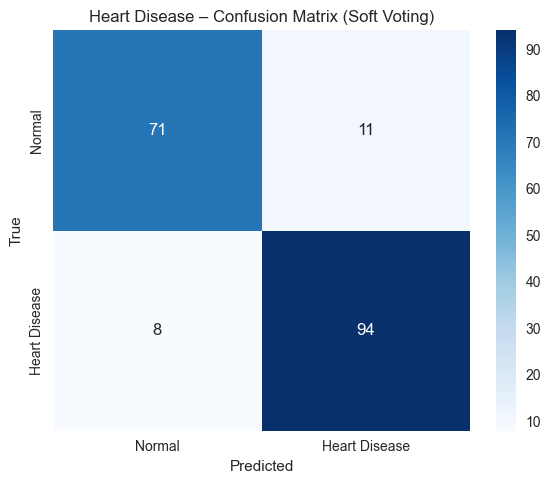

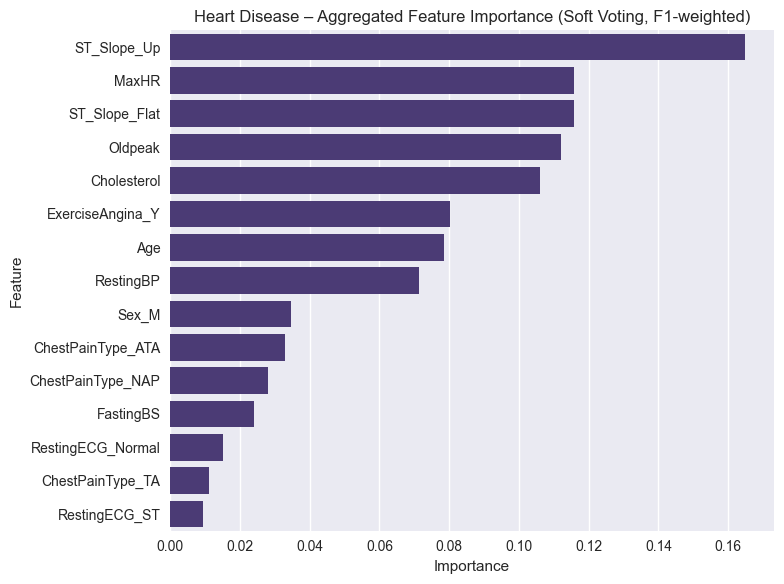

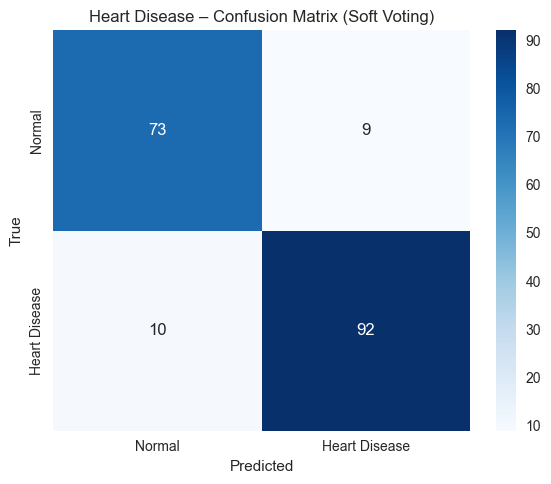

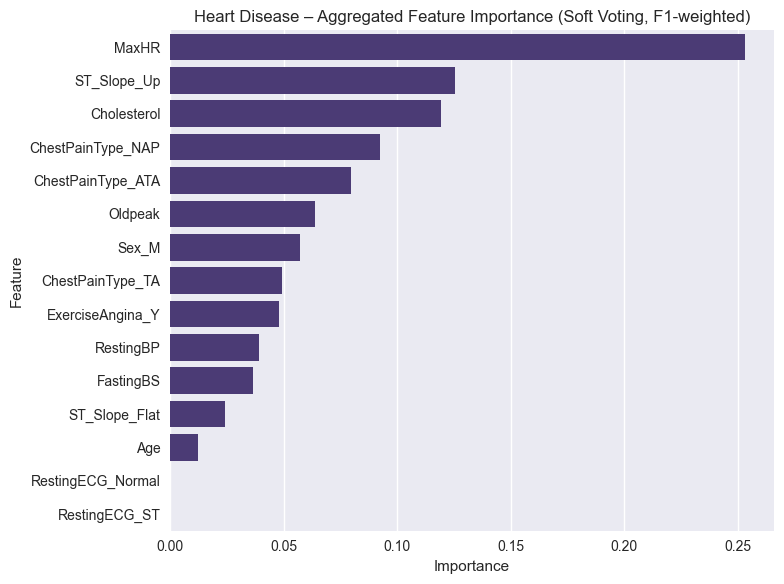

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

names = {dt_clf:'dt', rf_clf:'rf', ada_clf:'ada'}
for clf in (dt_clf, rf_clf, ada_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=sorted(label_map.keys()))

    plt.figure(figsize=(6, 5))
    sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[label_map[i] for i in sorted(label_map)],
    yticklabels=[label_map[i] for i in sorted(label_map)]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Heart Disease – Confusion Matrix (Soft Voting)")
    plt.tight_layout()
    plt.savefig("confusion_mat_" + names[clf] + ".svg", bbox_inches = 'tight');
    plt.show()

    # Generate classification report
    report = classification_report(y_test, y_pred, output_dict = True)
    report_df = pd.DataFrame(report)
    report_df
    # Save the report as a CSV File
    report_df.to_csv("class_report_" + names[clf] + ".csv") 

    # Storing importance values from the trained model
    importance = clf.feature_importances_
    # Storing feature importance as a dataframe
    feature_imp = pd.DataFrame(list(zip(X_train.columns, importance)),
                columns = ['Feature', 'Importance'])
    feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)
    plt.figure(figsize=(8, 6))
    sns.barplot(
        data=feature_imp,
        x="Importance",
        y="Feature"
    )
    plt.title("Heart Disease – Aggregated Feature Importance (Soft Voting, F1-weighted)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig("feature_imp_" + names[clf] + ".svg");
    plt.show()

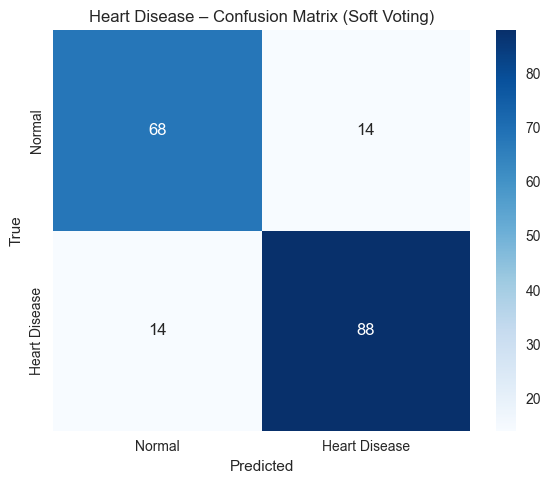

In [44]:
cm = confusion_matrix(y_test, y_pred_vote, labels=sorted(label_map.keys()))

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[label_map[i] for i in sorted(label_map)],
    yticklabels=[label_map[i] for i in sorted(label_map)]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Heart Disease – Confusion Matrix (Soft Voting)")
plt.tight_layout()
plt.savefig("confusion_mat_vote.svg", bbox_inches = 'tight');
plt.show()


In [45]:
report_dict = classification_report(
    y_test,
    y_pred_vote,
    target_names=[label_map[i] for i in sorted(label_map)],
    output_dict=True
)

report_df = pd.DataFrame(report_dict).T
report_df.to_csv("class_report_vote.csv")
report_df.head()


,precision,recall,f1-score,support
Normal,0.829268,0.829268,0.829268,82.000000
Heart Disease,0.862745,0.862745,0.862745,102.000000
accuracy,0.847826,0.847826,0.847826,0.847826
macro avg,0.846007,0.846007,0.846007,184.000000
weighted avg,0.847826,0.847826,0.847826,184.000000


In [46]:
rf_imp = rf_clf.feature_importances_
dt_imp = dt_clf.feature_importances_
ada_imp = ada_clf.feature_importances_

w_rf = weights_dict["Random Forest"]
w_dt = weights_dict["Decision Tree"]
w_ada = weights_dict["AdaBoost"]

agg_importances = w_rf * rf_imp + w_dt * dt_imp + w_ada * ada_imp

feat_imp_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": agg_importances
}).sort_values("importance", ascending=False)

feat_imp_df.head(10)


,feature,importance
14,ST_Slope_Up,0.273469
4,MaxHR,0.151190
2,Cholesterol,0.113976
5,Oldpeak,0.069147
12,ExerciseAngina_Y,0.054712
8,ChestPainType_NAP,0.049865
1,RestingBP,0.049063
13,ST_Slope_Flat,0.048449
0,Age,0.048367
6,Sex_M,0.041230


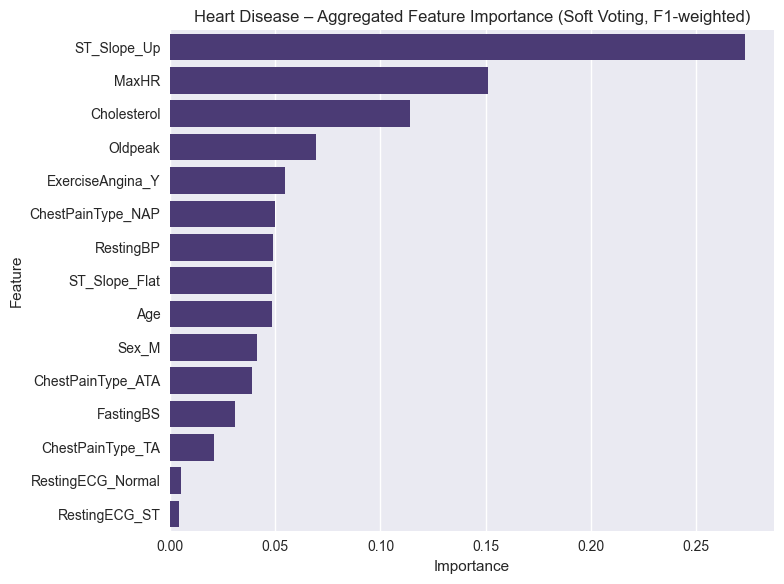

In [47]:
plt.figure(figsize=(8, 6))
sns.barplot(
    data=feat_imp_df,
    x="importance",
    y="feature"
)
plt.title("Heart Disease – Aggregated Feature Importance (Soft Voting, F1-weighted)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("feature_imp_vote.svg", dpi=300, bbox_inches="tight")
plt.show()


In [13]:
with open("model_rf_heart.pickle", "wb") as f:
    pickle.dump(rf_clf, f)

with open("model_dt_heart.pickle", "wb") as f:
    pickle.dump(dt_clf, f)

with open("model_ada_heart.pickle", "wb") as f:
    pickle.dump(ada_clf, f)

with open("model_vote_heart.pickle", "wb") as f:
    pickle.dump(voting_clf, f)
